#**Importando os dados:**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, train_test_split


# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('autos.csv', encoding = 'ISO-8859-1')

In [ ]:
df

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371523,2016-03-14 17:48:27,Suche_t4___vito_ab_6_sitze,privat,Angebot,2200,test,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,Angebot,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,nein,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,Angebot,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,nein,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
371526,2016-03-20 19:41:08,VW_Golf_Kombi_1_9l_TDI,privat,Angebot,3400,test,kombi,2002,manuell,100,golf,150000,6,diesel,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

**Retirei algumas outliers, pois alguns dados estão desconexos, por exemplo, veículos de 11 milhões de Euros, 99 milhões de Euros, preço abaixo dos 10 Euros, etc. Vamos retirar também a coluna de "dateCrawled", pois as datas na qual os clientes visualizam os veículos no site não influenciam no preço**

**Vamos retirar algumas colunas, algumas delas contém 2 tipos de amostras, sendo que um dos tipos só tem 3 amostras, não será válido, por exemplo, a "seller" é dividida em privada e comercial, só existe 3 amostras como comercial. e 371.525 privadas.**

In [ ]:
df = df[df["price"] > 10]
df = df[df["price"]< 30000]

In [ ]:
df.drop(columns=["dateCrawled", "name", "seller", "offerType", "nrOfPictures", "dateCreated", "postalCode", "lastSeen"], inplace=True)

In [ ]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN
1,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein
...,...,...,...,...,...,...,...,...,...,...,...,...
371523,2200,test,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
371524,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,nein
371525,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,nein
371526,3400,test,kombi,2002,manuell,100,golf,150000,6,diesel,volkswagen,NaN


**Verificando se há dados nulos**

In [ ]:
df.isna().sum()

price                      0
abtest                     0
vehicleType            33433
yearOfRegistration         0
gearbox                17048
powerPS                    0
model                  17572
kilometer                  0
monthOfRegistration        0
fuelType               29175
brand                      0
notRepairedDamage      65722
dtype: int64

**Excluindo os valores nulos, são poucos em relação ao número total de dados, não farão falta.**

In [ ]:
df.dropna(inplace=True)

In [ ]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein
5,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein
10,2000,control,limousine,2004,manuell,105,3_reihe,150000,12,benzin,mazda,nein
...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,control,limousine,2004,manuell,225,leon,150000,5,benzin,seat,ja
371521,1150,control,bus,2000,manuell,0,zafira,150000,3,benzin,opel,nein
371524,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,nein
371525,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,nein


**Uma rápida estatística**

In [ ]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration
count,252057.000000,252057.000000,252057.000000,252057.000000,252057.000000
mean,5969.237161,2003.260834,123.597365,125206.976993,6.199598
std,5980.303664,6.323118,140.427495,38734.286762,3.465187
min,11.000000,1923.000000,0.000000,5000.000000,0.000000
25%,1590.000000,1999.000000,77.000000,100000.000000,3.000000
50%,3800.000000,2004.000000,116.000000,150000.000000,6.000000
75%,8350.000000,2008.000000,150.000000,150000.000000,9.000000
max,29999.000000,2018.000000,20000.000000,150000.000000,12.000000


**Percebmos que só há variáveis numéricas com poucas correlações**

In [ ]:
df.corr()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration
price,1.000000,0.546365,0.229901,-0.452657,0.035456
yearOfRegistration,0.546365,1.000000,0.088808,-0.389198,0.031864
powerPS,0.229901,0.088808,1.000000,0.013096,0.015734
kilometer,-0.452657,-0.389198,0.013096,1.000000,-0.007352
monthOfRegistration,0.035456,0.031864,0.015734,-0.007352,1.000000


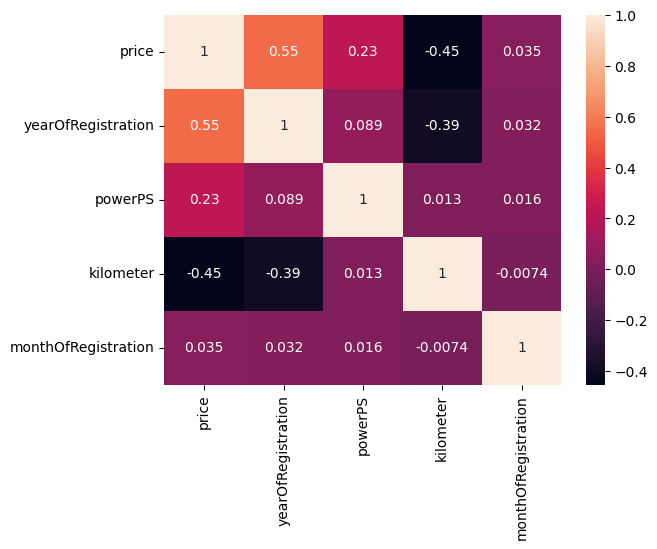

In [ ]:
sns.heatmap(df.corr(), annot=True);

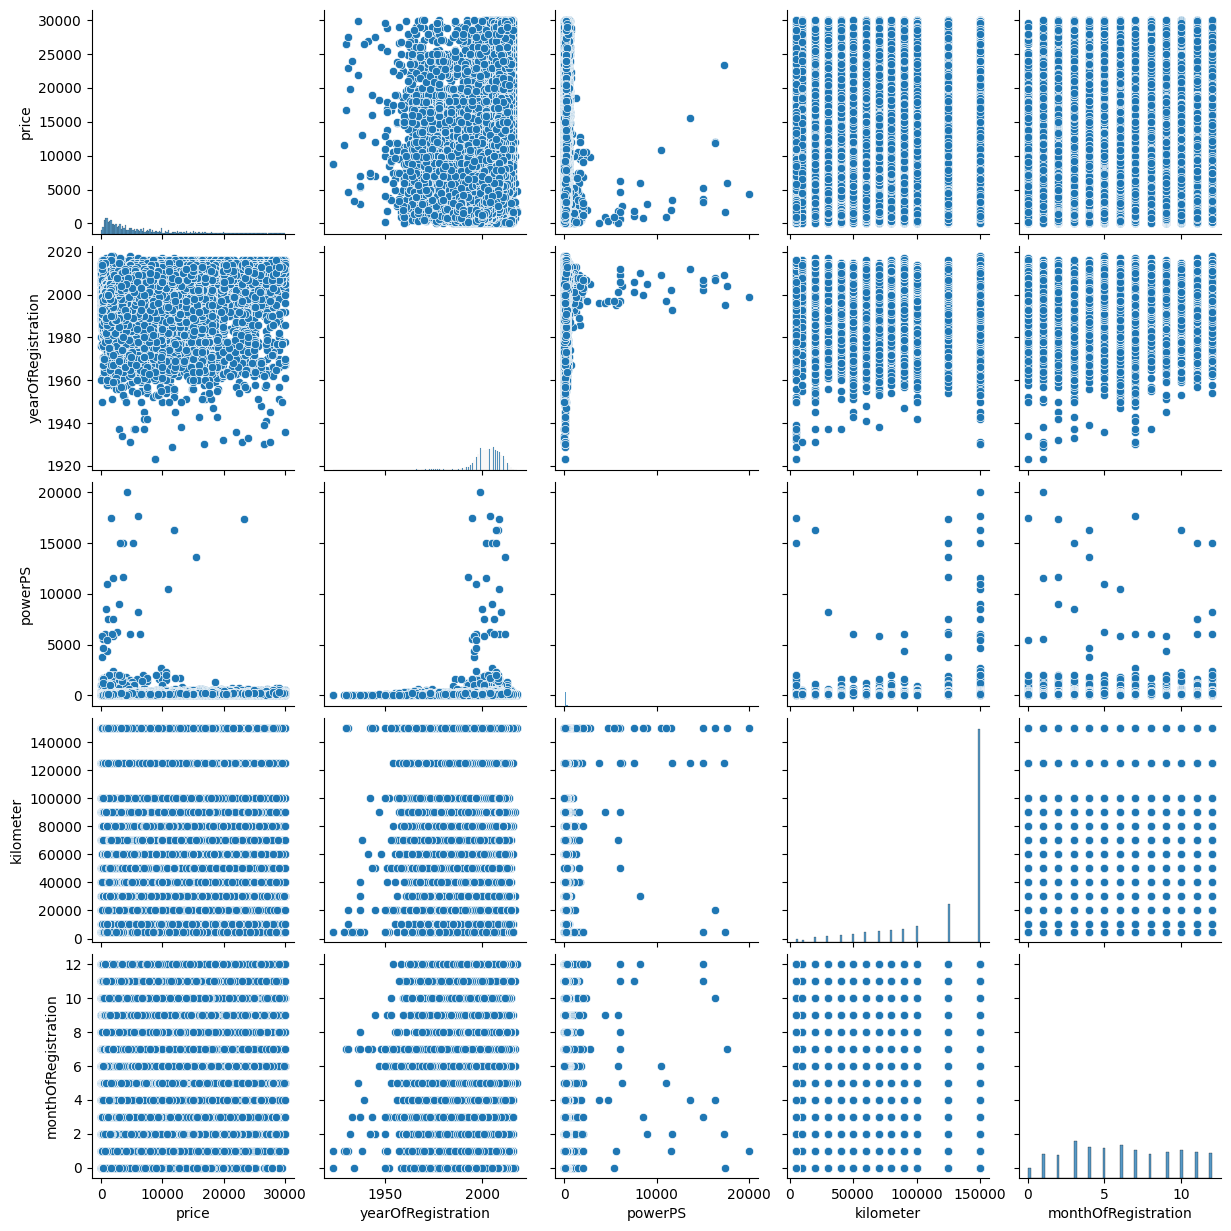

In [ ]:
sns.pairplot(df);

# **Fazendo o tratamento**

In [ ]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein
5,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein
10,2000,control,limousine,2004,manuell,105,3_reihe,150000,12,benzin,mazda,nein


**Vamos agora transformar as variáveis categóricas em numéricas, pois os estimadores só modelam dados numéricos.**

**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [ ]:
lista_ohe = ["abtest", "gearbox", "notRepairedDamage"]

for i in lista_ohe:  
  ohe =  OrdinalEncoder()
  ohe.fit(df[[i]])

  df[i]= ohe.transform(df[[i]])

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [ ]:
lista_oe = ["vehicleType", "model", "fuelType", "brand"] 

for i in lista_oe:  
  oe =  OrdinalEncoder()
  oe.fit(df[[i]])

  df[i]= oe.transform(df[[i]])

**Verificando a transformação. Perceba que as variáveis (colunas) que tinham dados categóricos passaram para numéricos, inclusive a coluna que tinha data.**

In [ ]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
3,1500,1.0,4.0,2001,1.0,75,117.0,150000,6,1.0,37.0,1.0
4,3600,1.0,4.0,2008,1.0,69,102.0,90000,7,3.0,31.0,1.0
5,650,1.0,6.0,1995,1.0,102,11.0,150000,10,1.0,2.0,0.0
6,2200,1.0,2.0,2004,1.0,109,8.0,150000,8,1.0,25.0,1.0
10,2000,0.0,6.0,2004,1.0,105,10.0,150000,12,1.0,19.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,0.0,6.0,2004,1.0,225,141.0,150000,5,1.0,30.0,0.0
371521,1150,0.0,1.0,2000,1.0,0,248.0,150000,3,1.0,24.0,1.0
371524,1199,1.0,2.0,2000,0.0,101,107.0,125000,3,1.0,32.0,1.0
371525,9200,1.0,1.0,1996,1.0,102,223.0,150000,3,3.0,37.0,1.0


**Agora vamos escalonar todos os dados para ficarem com dimensões próximas.**

In [ ]:
df.columns

Index(['price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType',
       'brand', 'notRepairedDamage'],
      dtype='object')

In [ ]:
ssc = StandardScaler()

ssc.fit(df[['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage']])
h= ssc.transform(df[['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage']])
df[['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage']] = h

**Vericando...todos os dados escalonados!! Exceto o target.**

In [ ]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
3,1500,0.962922,-0.247037,-0.357551,0.537309,-0.346068,0.249526,0.640081,-0.057601,-0.688930,1.295242,0.343435
4,3600,0.962922,-0.247037,0.749500,0.537309,-0.388795,0.039495,-0.908938,0.230984,1.159084,0.837173,0.343435
5,650,0.962922,0.926381,-1.306452,0.537309,-0.153798,-1.234692,0.640081,1.096740,-0.688930,-1.376827,-2.911756
6,2200,0.962922,-1.420455,0.116899,0.537309,-0.103950,-1.276698,0.640081,0.519570,-0.688930,0.379104,0.343435
10,2000,-1.038506,0.926381,0.116899,0.537309,-0.132434,-1.248694,0.640081,1.673911,-0.688930,-0.078965,0.343435
...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,-1.038506,0.926381,0.116899,0.537309,0.722101,0.585575,0.640081,-0.346186,-0.688930,0.760828,-2.911756
371521,1150,-1.038506,-2.007165,-0.515701,0.537309,-0.880152,2.083794,0.640081,-0.923357,-0.688930,0.302759,0.343435
371524,1199,0.962922,-1.420455,-0.515701,-1.861127,-0.160919,0.109505,-0.005344,-0.923357,-0.688930,0.913518,0.343435
371525,9200,0.962922,-2.007165,-1.148302,0.537309,-0.153798,1.733743,0.640081,-0.923357,1.159084,1.295242,0.343435


# **KNN Regressor**

**O KNN é um estimador onde o aprendizado é baseado “no quão similar” é um dado (um vetor) do outro. Como estamos tratando de regressão, talvez ele não seja válido, mas vamos testar.**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

**Chamando o KNN...**

In [ ]:
knn = KNeighborsRegressor()

**Fazendo a grade de parâmetros do KNN**

In [ ]:
param_grid_knn = {"weights" : ["uniform", "distance"],
                 "algorithm" : ["auto", "brute"],
                 "n_neighbors" : [2, 3, 5, 7, 9]}

**Vamos jogar para 10 splits**

In [ ]:
splitter = KFold(n_splits=10, random_state=1980, shuffle=True)

**Separando os dados de treino com os dados de teste.**

In [ ]:
X = df.drop(columns=["price"])
y = df["price"]

# Dividindo em dados de teste e dados de treino, peguei 30% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1080)

**Motando a grade geral dos parâmetros com o GridSearch**

In [ ]:
model_knn = GridSearchCV(estimator=knn,
                       param_grid=param_grid_knn ,
                       scoring="r2", 
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

model_knn.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=1980, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'brute'],
                         'n_neighbors': [2, 3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='r2', verbose=10)

In [ ]:
model_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}

**Overfitou os dados de treino no KNN, vamos seguir com outros estimadores para ver se conseguimos melhoras.**

In [ ]:
# Predições de treino
y_pred_train_knn = model_knn.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train_knn):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_knn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_knn)):.2f}")

# Predições de teste
y_pred_test_knn = model_knn.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test_knn):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_knn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_knn)):.2f}") 


Métricas de treino:

R^2: 0.99
MAE: 133.79
RMSE: 457.01

Métricas de teste:

R^2: 0.85
MAE: 1362.08
RMSE: 2345.08


In [ ]:
tabela_knn = pd.DataFrame()

In [ ]:
tabela_knn["Amostra existente"] = y_test

In [ ]:
tabela_knn["Predição"] = y_pred_test_knn

In [ ]:
tabela_knn["porcentagem de acerto %"]= (y_test/y_pred_test_knn)*100

In [ ]:
lista_num = []
for c in tabela_knn["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela_knn["porcentagem de acerto %"]= lista_num

In [ ]:
tabela_knn

,Amostra existente,Predição,porcentagem de acerto %
16266,1750,1265.969604,61.766033
114760,19800,19060.396030,96.119682
264310,1800,2274.695603,79.131467
124058,750,776.115239,96.635134
357543,5199,5440.907246,95.553917
...,...,...,...
263277,5850,3121.679379,12.600870
311732,9000,9294.273356,96.833821
357389,7000,5330.161787,68.671904
142065,950,809.800000,82.687083


Salvando a tabela

In [ ]:
tabela_knn.to_csv("01-knn_tabela_comparação.csv")

Salvando o estimador...

In [ ]:
import joblib

In [ ]:
joblib.dump(model_knn, 'knn_modelo.pkl')

['knn_modelo.pkl']

In [ ]:
knn_modelo = joblib.load('knn_modelo.pkl')

#**XGBoost Regressor**

**Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:**

In [ ]:
X = df.drop(columns=["price"])
y = df["price"]

# Dividindo em dados de teste e dados de treino, peguei 30% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1080)

**Chamando o XGBoost Regressor...**

In [ ]:
xgbr = XGBRegressor(eval_metric='logloss', random_state=42)

**Fazendo a grade de parâmetros do XGBoost Regressor**

In [ ]:
params_grid_xgbr = {"n_estimators": [2000], 
                   "max_depth": [3],  
                   "learning_rate": [0.01]} 

**Vamos jogar para 5 splits**

In [ ]:
splitter = KFold(n_splits=10, random_state=42, shuffle=True)

**Motando a grade geral dos parâmetros com o GridSearch**

In [ ]:
model_xgbr = GridSearchCV(estimator=xgbr,
                       param_grid=params_grid_xgbr,
                       scoring="r2", 
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

model_xgbr.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='logloss', feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=Non...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [3],
                         'n_estimators': [2000]},
             scoring='r2', verbose=10)

**Verificar as melhores métricas.**

In [ ]:
model_xgbr.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 2000}

**Vamos comparar as métricas de treino com as medições de teste.**

**Ótimos resultados**

In [ ]:
y_pred_train = model_xgbr.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")


y_pred_test = model_xgbr.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.87
MAE: 1333.79
RMSE: 2178.23

Métricas de teste:

R^2: 0.87
MAE: 1326.47
RMSE: 2163.06


Tabela de forma decrescente com as melhores métricas.

In [ ]:
xgbr_results = pd.DataFrame(model_xgbr.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,262.612443,1.654872,0.657804,0.226986,0.01,3,2000,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.872558,0.864944,...,0.855696,0.869317,0.861923,0.86382,0.864903,0.863784,0.867995,0.86481,0.004321,1


**Salvando o estimador...**

In [ ]:
import joblib

In [ ]:
joblib.dump(model_xgbr, 'xgbr_modelo.pkl')

['xgbr_modelo.pkl']

In [ ]:
xgbr_modelo = joblib.load('xgbr_modelo.pkl')

**Vamos agora fazer uma breve comparação entre os dados originais e os preditos.**

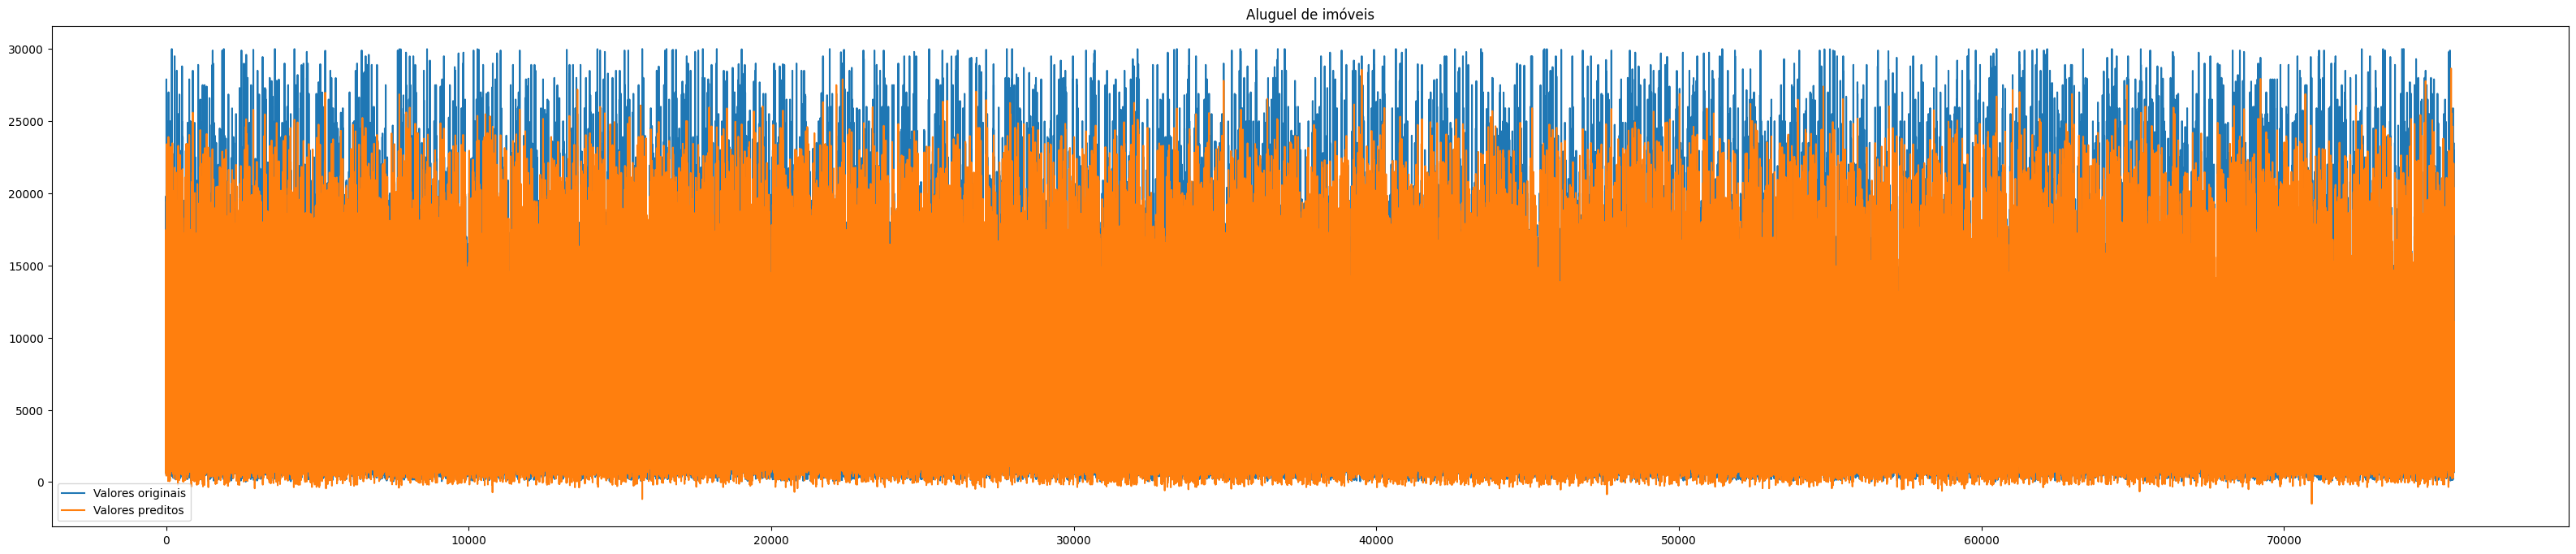

In [ ]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores originais")
plt.plot(x_ax, y_pred_test, label="Valores preditos")
plt.title("Aluguel de imóveis")
plt.legend()
plt.show();

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [ ]:
tabela = pd.DataFrame()

In [ ]:
tabela["valores reais"] = y_test

In [ ]:
tabela["valores preditos"] = y_pred_test

In [ ]:
tabela["porcentagem de acerto %"]= (y_test/y_pred_test)*100

In [ ]:
lista_num = []
for c in tabela["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela["porcentagem de acerto %"]= lista_num

In [ ]:
tabela

,valores reais,valores preditos,porcentagem de acerto %
16266,1750,1819.655151,96.172069
114760,19800,17477.283203,86.710081
264310,1800,1750.415894,97.167296
124058,750,604.194458,75.867779
357543,5199,4489.982910,84.208913
...,...,...,...
263277,5850,4628.167969,73.600093
311732,9000,9125.118164,98.628860
357389,7000,4045.152100,26.953355
142065,950,1173.689941,80.941309


In [ ]:
tabela.to_csv("06-xgbr_tabela_comparação.csv")

# **Otimização Bayesiana**



---



---



---



In [ ]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, KFold, train_test_split

from sklearn.pipeline import Pipeline

def pipe_pre_melbourne(drop_not_features=["price"], col_target="price",
                             inputer_num_strategy="mean",
                             encoding="ordinal"):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''

    X = df.drop(columns=drop_not_features)
    y = df[col_target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

In [ ]:
X_train, X_test, y_train, y_test, pre_processador = pipe_pre_melbourne(drop_not_features=["price"], 
                                                                            col_target="price",
                                                                            inputer_num_strategy="mean",
                                                                            encoding="ordinal")

In [ ]:
from hyperopt import hp, tpe, fmin, Trials, space_eval

In [ ]:
hps_space = {"learning_rate" : hp.choice("learning_rate", [0.001, 0.01]),
             "n_estimators" : hp.choice("n_estimators",  [500, 2000, 5000]),
             "max_depth" : hp.choice("max_depth", [2, 3, 5, 7]),
             "colsample_bytree": hp.choice("colsample_bytree", [0.1, 0.5, 0.9]),
             "subsample": hp.choice("subsample", [0.1, 0.5, 0.9])}
          

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
def objective(hps_space):
    
    pipe = Pipeline([("pp", pre_processador),
                     ("xgbr", XGBRegressor(**hps_space))])

    # =============================================

    splitter = KFold(n_splits=10, random_state=42, shuffle=True)

    results = cross_validate(pipe,
                             X_train, y_train, 
                             cv=splitter,
                             scoring="r2",
                             n_jobs=-1)

    r2 = results["test_score"].mean()

    return -r2

In [ ]:
ts = Trials()

best_hps = fmin(objective,
                space=hps_space,
                algo=tpe.suggest,
                trials=ts,
                max_evals=10)

100%|██████████| 10/10 [2:58:05<00:00, 1068.58s/trial, best loss: -0.8878606409863792]


In [54]:
# pré-resposta da otimização
best_hps

{'colsample_bytree': 2,
 'learning_rate': 1,
 'max_depth': 3,
 'n_estimators': 0,
 'subsample': 2}

In [55]:
# a resposta final, vem com o space_eval
best_hps = space_eval(hps_space, best_hps)
best_hps

{'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 7,
 'n_estimators': 500,
 'subsample': 0.9}

In [56]:
XGBRegressor(objective ='reg:squarederror', **best_hps)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):

    # Predições de treino
    y_pred_train_ob = estimator.predict(X_train)

    print("\nMétricas de treino:\n")
    print(f"R^2: {r2_score(y_train, y_pred_train_ob):.2f}")
    print(f"MAE: {mean_absolute_error(y_train, y_pred_train_ob):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_ob)):.2f}")

    # Predições de teste
    y_pred_test_ob = estimator.predict(X_test)

    print("\nMétricas de teste:\n")
    print(f"R^2: {r2_score(y_test, y_pred_test_ob):.2f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred_test_ob):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_ob)):.2f}") 

In [64]:
pipe = Pipeline([("pp", pre_processador),
                 ("xgbr", XGBRegressor(objective ='reg:squarederror', **best_hps))])

pipe.fit(X_train, y_train)

metricas_classificacao(pipe, X_train, X_test, y_train, y_test)


Métricas de treino:

R^2: 0.90
MAE: 1194.01
RMSE: 1938.08

Métricas de teste:

R^2: 0.89
MAE: 1210.83
RMSE: 2011.44


**Salvando o modelo:**

In [65]:
joblib.dump(model_xgbr, 'xgbr_ob_modelo.pkl')

['xgbr_ob_modelo.pkl']

In [ ]:
xgbr_ob_modelo = joblib.load('xgbr_ob_modelo.pkl')

**Apesar do XGBoost ter dado 88% a Otimização se saiu melhor pois os dados de treino e teste igualaram os valores em 87%**



---



---



---



#**Interpretando o modelo globalmente**

In [66]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
3,1500,0.962922,-0.247037,-0.357551,0.537309,-0.346068,0.249526,0.640081,-0.057601,-0.688930,1.295242,0.343435
4,3600,0.962922,-0.247037,0.749500,0.537309,-0.388795,0.039495,-0.908938,0.230984,1.159084,0.837173,0.343435
5,650,0.962922,0.926381,-1.306452,0.537309,-0.153798,-1.234692,0.640081,1.096740,-0.688930,-1.376827,-2.911756
6,2200,0.962922,-1.420455,0.116899,0.537309,-0.103950,-1.276698,0.640081,0.519570,-0.688930,0.379104,0.343435
10,2000,-1.038506,0.926381,0.116899,0.537309,-0.132434,-1.248694,0.640081,1.673911,-0.688930,-0.078965,0.343435
...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,-1.038506,0.926381,0.116899,0.537309,0.722101,0.585575,0.640081,-0.346186,-0.688930,0.760828,-2.911756
371521,1150,-1.038506,-2.007165,-0.515701,0.537309,-0.880152,2.083794,0.640081,-0.923357,-0.688930,0.302759,0.343435
371524,1199,0.962922,-1.420455,-0.515701,-1.861127,-0.160919,0.109505,-0.005344,-0.923357,-0.688930,0.913518,0.343435
371525,9200,0.962922,-2.007165,-1.148302,0.537309,-0.153798,1.733743,0.640081,-0.923357,1.159084,1.295242,0.343435


**SHAP**

In [ ]:
!pip install shap
import shap

In [68]:
X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [69]:
xgbr = XGBRegressor(objective ='reg:squarederror').fit(X_train, y_train)

In [70]:
explainer = shap.TreeExplainer(xgbr)

In [71]:
shap_vals = explainer.shap_values(X_train, check_additivity=False)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

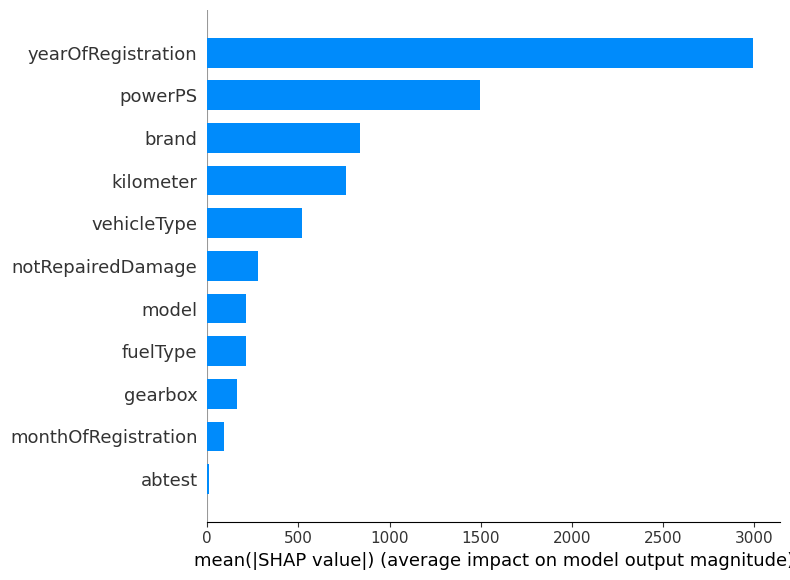

In [72]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")

# **Keras Regressor**

In [ ]:
!pip install scikeras

In [74]:
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from tensorflow.keras import backend as k 
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [75]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
3,1500,0.962922,-0.247037,-0.357551,0.537309,-0.346068,0.249526,0.640081,-0.057601,-0.688930,1.295242,0.343435
4,3600,0.962922,-0.247037,0.749500,0.537309,-0.388795,0.039495,-0.908938,0.230984,1.159084,0.837173,0.343435
5,650,0.962922,0.926381,-1.306452,0.537309,-0.153798,-1.234692,0.640081,1.096740,-0.688930,-1.376827,-2.911756
6,2200,0.962922,-1.420455,0.116899,0.537309,-0.103950,-1.276698,0.640081,0.519570,-0.688930,0.379104,0.343435
10,2000,-1.038506,0.926381,0.116899,0.537309,-0.132434,-1.248694,0.640081,1.673911,-0.688930,-0.078965,0.343435
...,...,...,...,...,...,...,...,...,...,...,...,...
371520,3200,-1.038506,0.926381,0.116899,0.537309,0.722101,0.585575,0.640081,-0.346186,-0.688930,0.760828,-2.911756
371521,1150,-1.038506,-2.007165,-0.515701,0.537309,-0.880152,2.083794,0.640081,-0.923357,-0.688930,0.302759,0.343435
371524,1199,0.962922,-1.420455,-0.515701,-1.861127,-0.160919,0.109505,-0.005344,-0.923357,-0.688930,0.913518,0.343435
371525,9200,0.962922,-2.007165,-1.148302,0.537309,-0.153798,1.733743,0.640081,-0.923357,1.159084,1.295242,0.343435


In [ ]:
X = df.drop(columns=["price"])
y = df["price"]

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#====================================================================================================
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    #k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform", input_dim=X_train.shape[1]), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
                #2ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2),
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'linear')])
    

    rn.compile(optimizer = optimizer, loss = "mean_absolute_error", metrics = ['mean_absolute_error'])


    return rn
#====================================================================================================
kr = KerasRegressor(model=criarRede)

pipe = Pipeline([('kr', kr)])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = KFold(n_splits=10, random_state=42, shuffle=True)

# Opitmização de Hiperparêmetros
params = {"kr__optimizer": ["adam"],
          "kr__batch_size": [20],
          "kr__epochs":[100]} 
#====================================================================================================
#Motando a grade geral de parâmetros.
grid_kr_keras = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring="neg_mean_absolute_error",
                       cv=splitter,
                       verbose=10)

grid_kr_keras.fit(X_train, y_train)

In [78]:
grid_kr_keras.best_params_

{'kr__batch_size': 20, 'kr__epochs': 100, 'kr__optimizer': 'adam'}

In [79]:
grid_kr_keras.best_score_

nan

In [80]:
y_pred = grid_kr_keras.predict(X_test)

2521/2521 [==============================] - 3s 1ms/step


In [81]:
y_pred

array([2264.939 , 3440.2524, 6993.467 , ..., 1446.6313, 1429.3516,
       1278.4569], dtype=float32)

In [82]:
tabela = pd.DataFrame()

In [83]:
tabela["Valor real"] = y_test

In [84]:
tabela["Valor preditivo"] = y_pred

In [87]:
tabela["porcentagem de acerto %"]= (y_test/y_pred)*100

In [88]:
lista_num = []
for c in tabela["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela["porcentagem de acerto %"]= lista_num

In [89]:
tabela = tabela.sort_index()
tabela = tabela.reset_index()
tabela 

,index,Valor real,Valor preditivo,porcentagem de acerto %
0,10,2000,3365.972656,59.418189
1,14,17999,15793.235352,86.033485
2,21,3699,6375.778809,58.016442
3,23,450,1091.358032,41.233031
4,39,1500,2202.098389,68.116847
...,...,...,...,...
50407,371491,3200,2847.041016,87.602603
50408,371500,20400,17198.464844,81.384762
50409,371513,4400,5842.657715,75.308194
50410,371525,9200,2192.489502,219.614324


In [90]:
lista = []
for c in range(tabela.shape[0]):
  if tabela.loc[[c]].values[0][2] < tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][2] / tabela.loc[[c]].values[0][1])*100
      lista.append(valor)
  elif tabela.loc[[c]].values[0][2] > tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][1] / tabela.loc[[c]].values[0][2])*100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 71.34%


In [91]:
joblib.dump(model_xgbr, 'grid_kr_keras.pkl')

['grid_kr_keras.pkl']

In [ ]:
grid_kr_keras = joblib.load('grid_kr_keras.pkl')